# Telecom company churn prediction example

By Will(Xiaochun) Ma

2018/01/09

The data comes from an example dataset of IBM Analytics. Here is the link:https://community.watsonanalytics.com/wp-content/uploads/2015/03/WA_Fn-UseC_-Telco-Customer-Churn.xlsx

## 1. Import packages

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import time
import pylab as pl
from IPython import display

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve
from sklearn.preprocessing import MinMaxScaler

from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from sklearn.neural_network import MLPClassifier

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## 2. Read file

In [2]:
telecom = pd.read_csv('telecom.csv')

In [3]:
# Take a look at the dataframe
telecom.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## 3. Data Cleaning ,EDA and Feature Engineering

** Find and count NAs **: 

The function below is to detect NA values column by column, and return column names as well as the number of NAs if there is any NA value in the column.

In [4]:
def na_detection():
    res = {}
    for c in telecom.columns:
        na_sum = sum(pd.isnull(telecom[c]))
        if na_sum != 0:
            res[c] = na_sum
    return res

In [5]:
# There is no NAs in any column of the dataset, which is nice!
na_detection()

{}

However, I found there are empty spaces in the column of 'TotalCharges', which are potenital NAs. After checking the corresponding data I found they share same characteristics: the tenue is 0. So I believe the 'TotalCharges'for these rows should be 0.

In [6]:
telecom[telecom['TotalCharges'].str.contains(r'\s+')] = telecom[telecom['TotalCharges'].str.contains(r'\s+')].assign(TotalCharges = 0)
telecom['TotalCharges'] = pd.to_numeric(telecom['TotalCharges'])

Following are some data visualization aimed to find closely related categorical features with respect to "Churn" and density distribution plot of continous features.

In [7]:
def count_plot(feature, hue_feature= None):
    sns.set(style="whitegrid")
    sns.countplot(x=feature,hue=hue_feature,data=telecom)
    plt.show()

In [8]:
def dist_plot(feature):
    sns.set(style="whitegrid")
    sns.distplot(telecom[feature])
    plt.show()

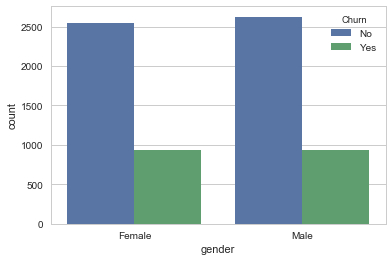

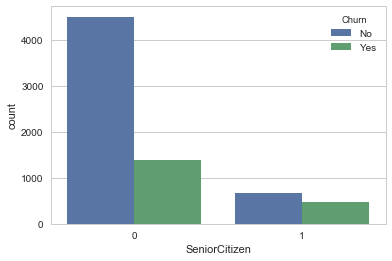

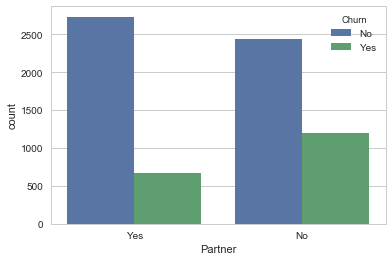

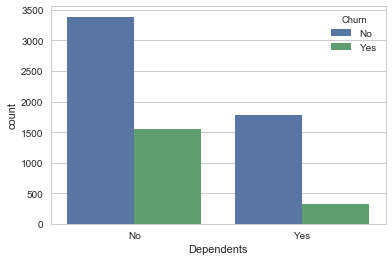

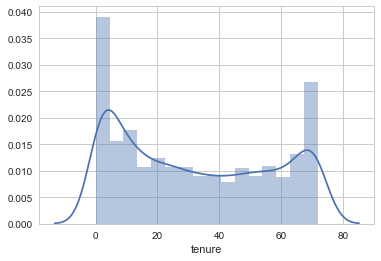

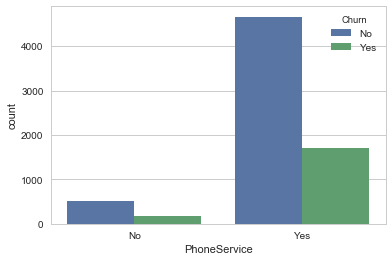

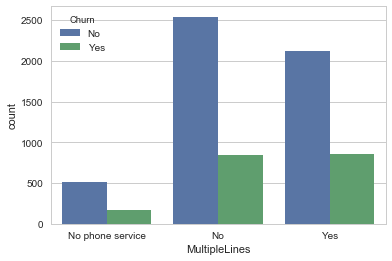

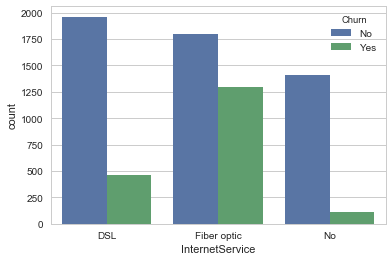

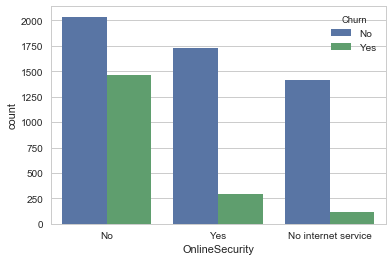

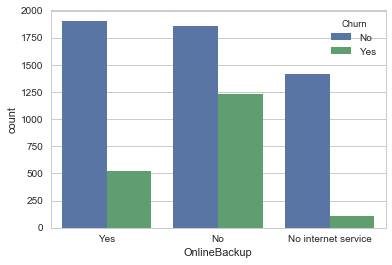

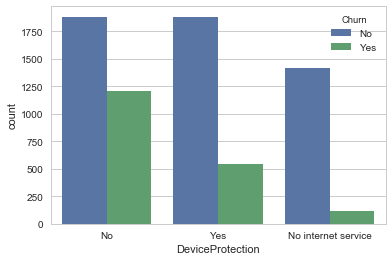

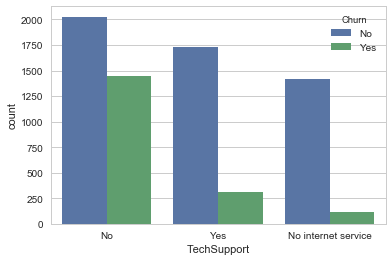

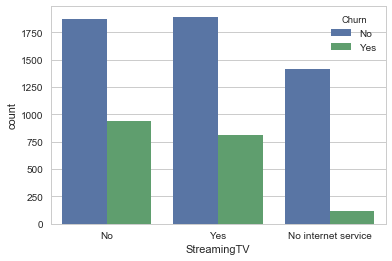

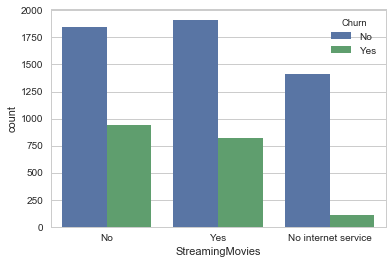

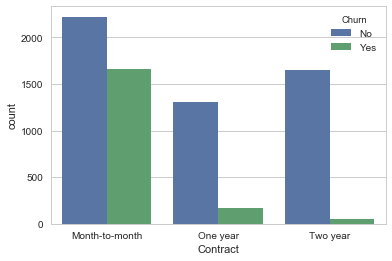

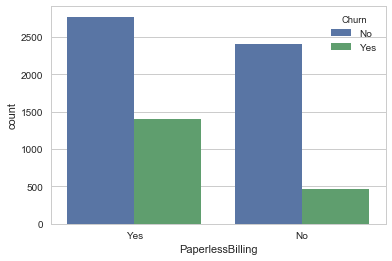

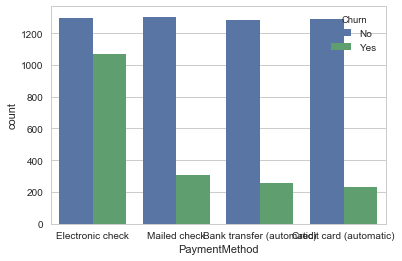

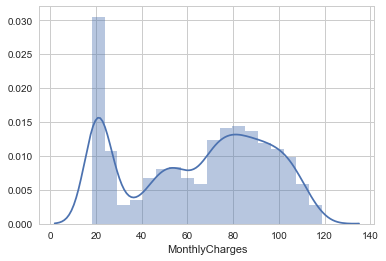

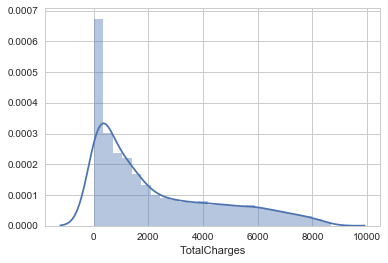

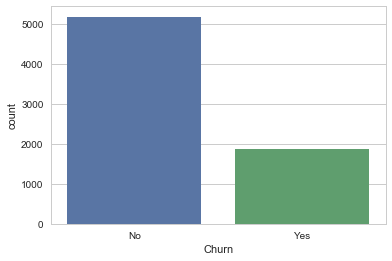

In [9]:
for feature in telecom.columns[1:]:
    if feature == 'Churn':
        count_plot(feature)
    elif type(telecom[feature][0]) is str or feature == 'SeniorCitizen':
        count_plot(feature, hue_feature= 'Churn')
    else:
        dist_plot(feature)

** Convert categorical data to numbers **: 

The function below is to convert categorical data to numbers, and at the same time keep the records of the mapping for later model interpretation.

In [37]:
def category_to_number():
    telecom_cat2num = telecom.copy()
    mapping_record = {}
    for c in telecom_cat2num.columns:
        if c == 'Contract':
            conditions = [telecom_cat2num[c] == 'Month-to-month', 
                          telecom_cat2num[c] == 'One year', 
                          telecom_cat2num[c] == 'Two year']
            conditions_cache = ['Month-to-month', 'One year', 'Two year']
            choices = [1, 12, 24]
            telecom_cat2num[c] = np.select(conditions, choices, default=1)
            mapping_record[c] = dict(zip(conditions_cache, choices))
        elif c in ['DeviceProtection', 'OnlineBackup', 
                   'OnlineSecurity', 'StreamingMovies', 
                   'StreamingTV', 'TechSupport']:
            conditions = [telecom_cat2num[c] == 'No', 
                          telecom_cat2num[c] == 'No internet service', 
                          telecom_cat2num[c] == 'Yes']
            conditions_cache = ['No', 'No internet service', 'Yes']
            choices = [0, 0, 1]
            telecom_cat2num[c] = np.select(conditions, choices, default=0)
            mapping_record[c] = dict(zip(conditions_cache, choices))
        elif c == 'MultipleLines':
            conditions = [telecom_cat2num[c] == 'No', 
                          telecom_cat2num[c] == 'No phone service', 
                          telecom_cat2num[c] == 'Yes']
            conditions_cache = ['No', 'No phone service', 'Yes']
            choices = [0, 0, 1]
            telecom_cat2num[c] = np.select(conditions, choices, default=0)
            mapping_record[c] = dict(zip(conditions_cache, choices))
        elif c == 'InternetService':
            conditions = [telecom_cat2num[c] == 'No', 
                          telecom_cat2num[c] == 'DSL', 
                          telecom_cat2num[c] == 'Fiber optic']
            conditions_cache = ['No', 'DSL', 'Fiber optic']
            choices1 = [0, 1, 1]
            choices2 = [0, 1, 2]
            telecom_cat2num[c] = np.select(conditions, choices1, default=0)
            mapping_record[c] = dict(zip(conditions_cache, choices1))
            telecom_cat2num['InternetQuality'] = np.select(conditions, choices2, default=0)
            mapping_record['InternetQuality'] = dict(zip(conditions_cache, choices2))
        elif c == 'PaymentMethod':
            conditions = [telecom_cat2num[c] == 'Mailed check', 
                          telecom_cat2num[c] == 'Electronic check', 
                          telecom_cat2num[c] == 'Credit card (automatic)',
                          telecom_cat2num[c] == 'Bank transfer (automatic)']
            conditions_cache = ['Mailed check', 'Electronic check', 
                                'Credit card (automatic)',
                               'Bank transfer (automatic)']
            choices = [1, 2, 3, 4]
            telecom_cat2num[c] = np.select(conditions, choices, default=0)
            mapping_record[c] = dict(zip(conditions_cache, choices))
        elif (type(telecom_cat2num[c][0]) is str 
            and c not in ['customerID','TotalCharges']):
            le = LabelEncoder()
            le.fit(telecom_cat2num[c])
            mapping_record[c] = dict(zip(le.classes_, range(len(le.classes_))))
            telecom_cat2num[c] = le.transform(telecom_cat2num[c])
    return telecom_cat2num, mapping_record

In [38]:
telecom_cat2num, mapping_record = category_to_number()

In [39]:
telecom_cat2num.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,InternetQuality
0,7590-VHVEG,0,0,1,0,1,0,0,1,0,...,0,0,0,1,1,2,29.85,29.85,0,1
1,5575-GNVDE,1,0,0,0,34,1,0,1,1,...,0,0,0,12,0,1,56.95,1889.50,0,1
2,3668-QPYBK,1,0,0,0,2,1,0,1,1,...,0,0,0,1,1,1,53.85,108.15,1,1
3,7795-CFOCW,1,0,0,0,45,0,0,1,1,...,1,0,0,12,0,4,42.30,1840.75,0,1
4,9237-HQITU,0,0,0,0,2,1,0,1,0,...,0,0,0,1,1,2,70.70,151.65,1,2


In [40]:
mapping_record

{'Churn': {'No': 0, 'Yes': 1},
 'Contract': {'Month-to-month': 1, 'One year': 12, 'Two year': 24},
 'Dependents': {'No': 0, 'Yes': 1},
 'DeviceProtection': {'No': 0, 'No internet service': 0, 'Yes': 1},
 'InternetQuality': {'DSL': 1, 'Fiber optic': 2, 'No': 0},
 'InternetService': {'DSL': 1, 'Fiber optic': 1, 'No': 0},
 'MultipleLines': {'No': 0, 'No phone service': 0, 'Yes': 1},
 'OnlineBackup': {'No': 0, 'No internet service': 0, 'Yes': 1},
 'OnlineSecurity': {'No': 0, 'No internet service': 0, 'Yes': 1},
 'PaperlessBilling': {'No': 0, 'Yes': 1},
 'Partner': {'No': 0, 'Yes': 1},
 'PaymentMethod': {'Bank transfer (automatic)': 4,
  'Credit card (automatic)': 3,
  'Electronic check': 2,
  'Mailed check': 1},
 'PhoneService': {'No': 0, 'Yes': 1},
 'StreamingMovies': {'No': 0, 'No internet service': 0, 'Yes': 1},
 'StreamingTV': {'No': 0, 'No internet service': 0, 'Yes': 1},
 'TechSupport': {'No': 0, 'No internet service': 0, 'Yes': 1},
 'gender': {'Female': 0, 'Male': 1}}

In [52]:
def feature_engineering():
    telecom_fe = telecom_cat2num.copy()
    #Build new feature 1: Singple person or not?
    telecom_fe['Single'] = np.where((telecom_fe['Partner'] == 0) & (telecom_fe['Dependents'] == 0), 0, 1)
    #Build new feature 2: Number of Services
    telecom_fe['NumOfServices'] = telecom_fe[['PhoneService','StreamingMovies', 
                                             'StreamingTV', 'InternetService']].sum(axis=1)
    #Build new feature 3: Quality of Services
    telecom_fe['QualityOfServices'] = telecom_fe[['InternetQuality','DeviceProtection',
                                              'MultipleLines', 'OnlineBackup', 
                                              'OnlineSecurity',  'TechSupport']].sum(axis=1)
    #Build new feature 4: Paying behavior score
    telecom_fe['PayBehaviorScore'] = telecom_fe[['PaperlessBilling','PaymentMethod']].sum(axis=1)
    return telecom_fe

In [53]:
telecom_fe = feature_engineering()
telecom_fe.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,InternetQuality,Single,NumOfServices,QualityOfServices,PayBehaviorScore
0,7590-VHVEG,0,0,1,0,1,0,0,1,0,...,1,2,29.85,29.85,0,1,1,1,2,3
1,5575-GNVDE,1,0,0,0,34,1,0,1,1,...,0,1,56.95,1889.50,0,1,0,2,3,1
2,3668-QPYBK,1,0,0,0,2,1,0,1,1,...,1,1,53.85,108.15,1,1,0,2,3,2
3,7795-CFOCW,1,0,0,0,45,0,0,1,1,...,0,4,42.30,1840.75,0,1,0,1,4,4
4,9237-HQITU,0,0,0,0,2,1,0,1,0,...,1,2,70.70,151.65,1,2,0,2,2,3


This correlation plot is used to find relations between every pair of features. More attention should be paied to features which are obviously positively or negatively related to "Churn".

These feaures include:
**"SeniorCitizen","tenure","OnlineSecurity","Contract", "PaperLessPaying","PaymentMethod","MonthlyCharges" and "TotalCharges".**

In [18]:
def cor_plot(df):
    
    sns.set(style="white")
    sns.set_context("talk")
    corr = df.corr()
    fig, ax = plt.subplots(figsize=(15,15))
    sns.heatmap(corr, cmap="YlGnBu",square=True)

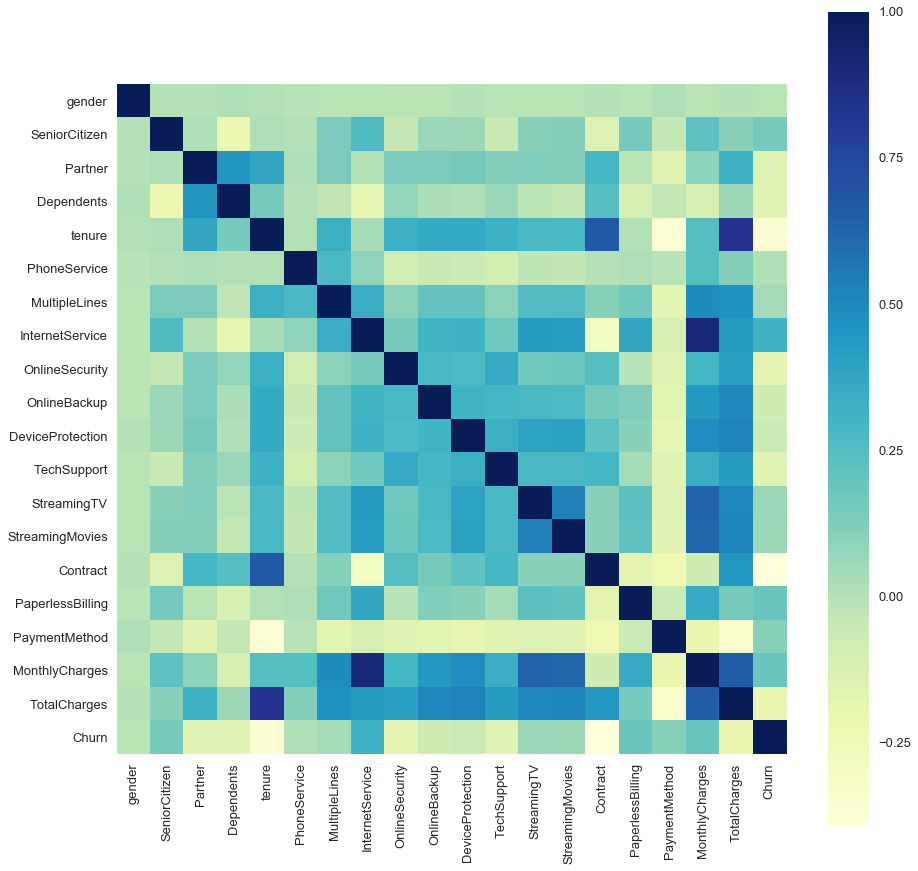

In [19]:
cor_plot(telecom_cat2num)

**Try the feature-engineered data. **

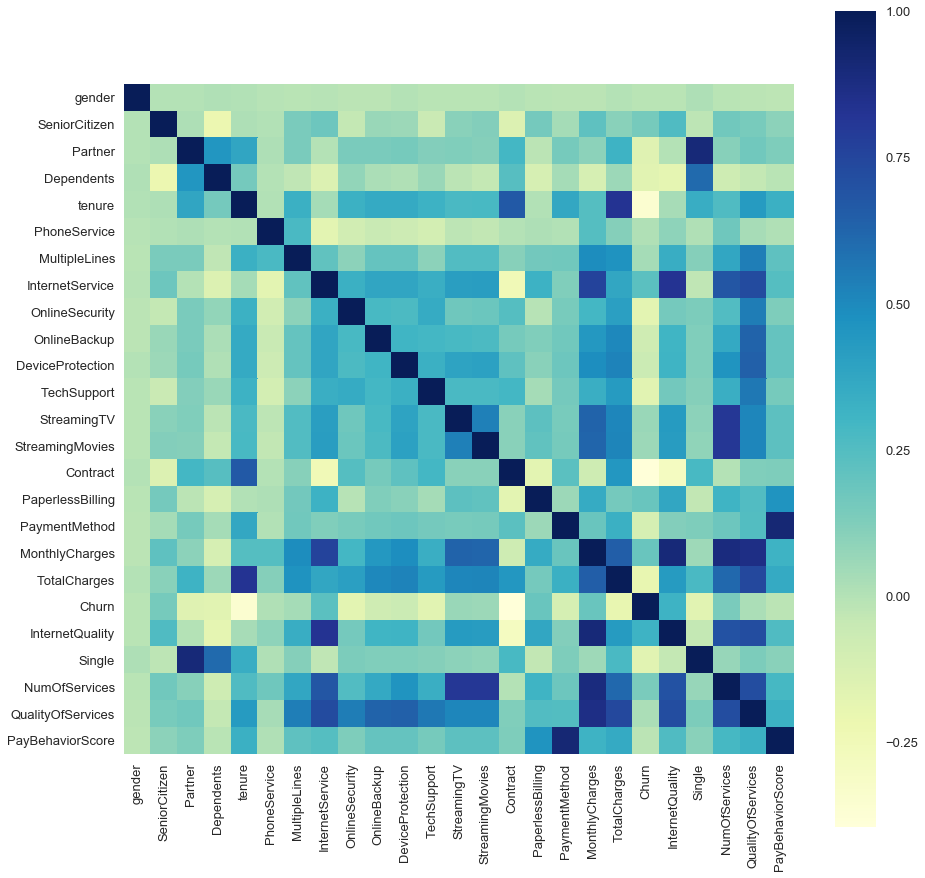

In [54]:
cor_plot(telecom_fe)

** Separate customer ID and data **: 

The function below is to separate customer ID and data so that ID will not be considered by models, which otherwise would be a noise feature. At the same time, cache the ids for later loopup.

In [55]:
def separate_ID(df):
    telecom_no_id = df.copy()
    ids = telecom_no_id['customerID']
    telecom_no_id = telecom_no_id.drop('customerID', 1)
    return telecom_no_id, ids

In [56]:
telecom_no_id, ids = separate_ID(telecom_cat2num)

In [57]:
telecom_fe_no_id, ids = separate_ID(telecom_fe)

In [13]:
telecom_no_id.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,29.85,0
1,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,56.95,1889.50,0
2,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,53.85,108.15,1
3,1,0,0,0,45,0,1,0,2,0,2,2,0,0,1,0,0,42.30,1840.75,0
4,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,151.65,1


In [58]:
telecom_fe_no_id.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,InternetQuality,Single,NumOfServices,QualityOfServices,PayBehaviorScore
0,0,0,1,0,1,0,0,1,0,1,...,1,2,29.85,29.85,0,1,1,1,2,3
1,1,0,0,0,34,1,0,1,1,0,...,0,1,56.95,1889.50,0,1,0,2,3,1
2,1,0,0,0,2,1,0,1,1,1,...,1,1,53.85,108.15,1,1,0,2,3,2
3,1,0,0,0,45,0,0,1,1,0,...,0,4,42.30,1840.75,0,1,0,1,4,4
4,0,0,0,0,2,1,0,1,0,0,...,1,2,70.70,151.65,1,2,0,2,2,3


** Split dataframe into training data and test data **: 

The code below is to split dataframe into training data and test data using a 80:20 proportion.

In [59]:
X_telecom, y_telecom = telecom_no_id.loc[:,'gender':'TotalCharges'], telecom_no_id['Churn']

X_train, X_test, y_train, y_test = train_test_split(X_telecom, y_telecom, test_size=0.2, random_state=0)

X_telecom_fe, y_telecom_fe = telecom_fe_no_id.loc[:,telecom_fe_no_id.columns != 'Churn'], telecom_fe_no_id['Churn']

X_train_fe, X_test_fe, y_train_fe, y_test_fe = train_test_split(X_telecom_fe, y_telecom_fe, test_size=0.2, random_state=0)

** Normalize the data **: 

In [60]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
feature_names = X_telecom.columns
X_train_scaled = pd.DataFrame(data=X_train_scaled, columns=feature_names)
X_test_scaled = pd.DataFrame(data=X_test_scaled, columns=feature_names)

scaler_fe = MinMaxScaler()
X_train_fe_scaled = scaler_fe.fit_transform(X_train_fe)
X_test_fe_scaled = scaler_fe.transform(X_test_fe)
feature_names_fe = X_telecom_fe.columns
X_train_fe_scaled = pd.DataFrame(data=X_train_fe_scaled, columns=feature_names_fe)
X_test_fe_scaled = pd.DataFrame(data=X_test_fe_scaled, columns=feature_names_fe)

## 4. Building models and model selection

**Cross Validation function to tune parameters**

In [70]:
def CV_parameter(classifier_name, parameter_name, train_scores, test_scores, param_range = np.logspace(-3, 3, 10)):
    plt.figure()

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.title('Validation Curve with ' + classifier_name)
    plt.xlabel('Parameter ' + parameter_name)
    plt.ylabel('Score')
    plt.ylim(0.0, 1.1)
    lw = 2

    plt.semilogx(param_range, train_scores_mean, label='Training score',
                color='darkorange', lw=lw)

    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.2,
                    color='darkorange', lw=lw)

    plt.semilogx(param_range, test_scores_mean, label='Cross-validation score',
                color='navy', lw=lw)

    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.2,
                    color='navy', lw=lw)

    plt.legend(loc='best')
    plt.show()

In [71]:
def model_selection_plot(classifier_name, classifier, parameter_name , param_range = np.logspace(-3, 3, 10)):
    #param_range = np.logspace(-3, 3, 10)
    train_scores, test_scores = validation_curve(classifier, X_train_scaled, y_train,
                                                param_name=parameter_name,
                                                param_range=param_range, cv=5)
    CV_parameter(classifier_name, parameter_name, train_scores, test_scores)

** Use Linear SVM Classifier **: 

Accuracy of Linear SVC classifier on training set: 0.80
Accuracy of Linear SVC classifier on test set: 0.79


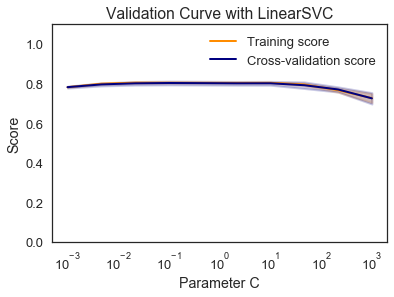

In [72]:
clf = LinearSVC(C=5, random_state = 17).fit(X_train_scaled, y_train)
print('Accuracy of Linear SVC classifier on training set: {:.2f}'
     .format(clf.score(X_train_scaled, y_train)))
print('Accuracy of Linear SVC classifier on test set: {:.2f}'
     .format(clf.score(X_test_scaled, y_test)))
model_selection_plot('LinearSVC',LinearSVC(), 'C')

**LinearSVC with feature-engineered data**

Accuracy of Linear SVC classifier on training set: 0.81
Accuracy of Linear SVC classifier on test set: 0.80


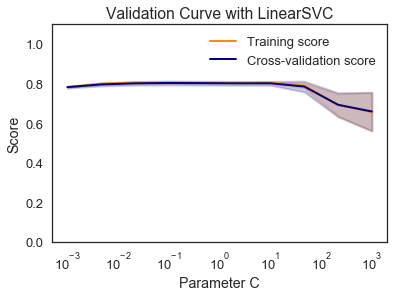

In [77]:
clf = LinearSVC(C=5, random_state = 17).fit(X_train_fe_scaled, y_train)
print('Accuracy of Linear SVC classifier on training set: {:.2f}'
     .format(clf.score(X_train_fe_scaled, y_train)))
print('Accuracy of Linear SVC classifier on test set: {:.2f}'
     .format(clf.score(X_test_fe_scaled, y_test)))
model_selection_plot('LinearSVC',LinearSVC(), 'C')

** Use Logistic Regression Classifier **: 

Accuracy of LogisticRegression classifier on training set: 0.81
Accuracy of LogisticRegression classifier on test set: 0.80


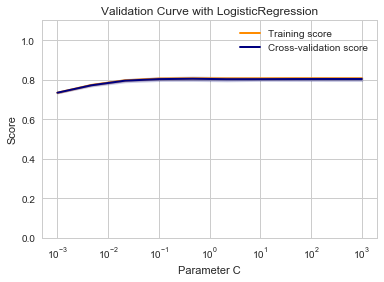

In [84]:
clf = LogisticRegression(C=1).fit(X_train_scaled, y_train)

print('Accuracy of LogisticRegression classifier on training set: {:.2f}'
     .format(clf.score(X_train_scaled, y_train)))
print('Accuracy of LogisticRegression classifier on test set: {:.2f}'
     .format(clf.score(X_test_scaled, y_test)))
model_selection_plot('LogisticRegression', LogisticRegression(),'C')

**LogisticRegression with feature-engineered data**

Accuracy of LogisticRegression classifier on training set: 0.81
Accuracy of LogisticRegression classifier on test set: 0.79


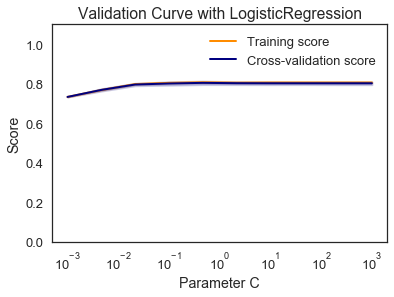

In [78]:
clf = LogisticRegression(C=1).fit(X_train_fe_scaled, y_train)

print('Accuracy of LogisticRegression classifier on training set: {:.2f}'
     .format(clf.score(X_train_fe_scaled, y_train)))
print('Accuracy of LogisticRegression classifier on test set: {:.2f}'
     .format(clf.score(X_test_fe_scaled, y_test)))
model_selection_plot('LogisticRegression', LogisticRegression(),'C')

** Use DecisionTree Classifier **: 

Accuracy of DecisionTree classifier on training set: 0.79
Accuracy of DecisionTree classifier on test set: 0.77


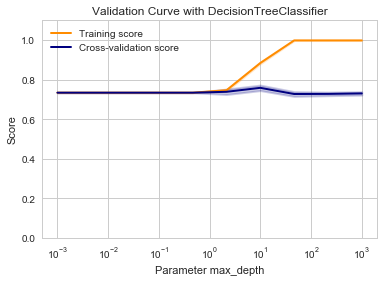

In [85]:
clf = DecisionTreeClassifier(max_depth = 3).fit(X_train_scaled, y_train)

print('Accuracy of DecisionTree classifier on training set: {:.2f}'
     .format(clf.score(X_train_scaled, y_train)))
print('Accuracy of DecisionTree classifier on test set: {:.2f}'
     .format(clf.score(X_test_scaled, y_test)))
model_selection_plot('DecisionTreeClassifier', DecisionTreeClassifier(),'max_depth')

** DecisionTree Classifier with feature-engineered data **: 

Accuracy of DecisionTree classifier on training set: 0.80
Accuracy of DecisionTree classifier on test set: 0.78


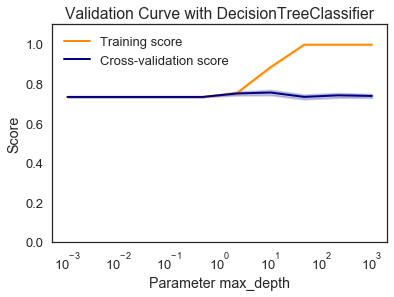

In [80]:
clf = DecisionTreeClassifier(max_depth = 5).fit(X_train_fe_scaled, y_train)

print('Accuracy of DecisionTree classifier on training set: {:.2f}'
     .format(clf.score(X_train_fe_scaled, y_train)))
print('Accuracy of DecisionTree classifier on test set: {:.2f}'
     .format(clf.score(X_test_fe_scaled, y_test)))
model_selection_plot('DecisionTreeClassifier', DecisionTreeClassifier(),'max_depth')

** Use RandomForest Classifier **:

Accuracy of Randomforest classifier on training set: 0.81
Accuracy of Randomforest classifier on test set: 0.78


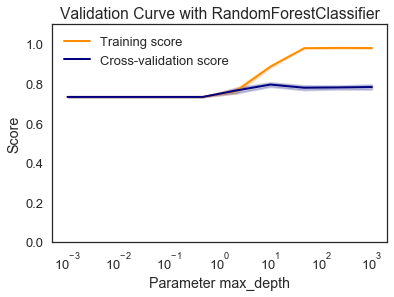

In [86]:
clf = RandomForestClassifier(max_depth=5, random_state=0).fit(X_train_scaled, y_train)
print('Accuracy of Randomforest classifier on training set: {:.2f}'
     .format(clf.score(X_train_scaled, y_train)))
print('Accuracy of Randomforest classifier on test set: {:.2f}'
     .format(clf.score(X_test_scaled, y_test)))
model_selection_plot('RandomForestClassifier', RandomForestClassifier(),'max_depth')

** RandomForest Classifier with feature-engineered data **: 

Accuracy of Randomforest classifier on training set: 0.80
Accuracy of Randomforest classifier on test set: 0.79


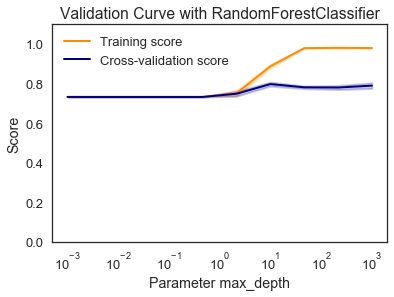

In [85]:
clf = RandomForestClassifier(max_depth=5, random_state=0).fit(X_train_fe_scaled, y_train)
print('Accuracy of Randomforest classifier on training set: {:.2f}'
     .format(clf.score(X_train_fe_scaled, y_train)))
print('Accuracy of Randomforest classifier on test set: {:.2f}'
     .format(clf.score(X_test_fe_scaled, y_test)))
model_selection_plot('RandomForestClassifier', RandomForestClassifier(),'max_depth')

** Use GradientBoosting Classifier **:

In [88]:
clf = GradientBoostingClassifier().fit(X_train_scaled, y_train)
print('Accuracy of GradientBoostingClassifier on training set: {:.2f}'
     .format(clf.score(X_train_scaled, y_train)))
print('Accuracy of GradientBoostingClassifier on test set: {:.2f}'
     .format(clf.score(X_test_scaled, y_test)))

Accuracy of GradientBoostingClassifier on training set: 0.83
Accuracy of GradientBoostingClassifier on test set: 0.79


** GradientBoosting Classifier with feature-engineered data **: 

In [89]:
clf = GradientBoostingClassifier().fit(X_train_fe_scaled, y_train)
print('Accuracy of GradientBoostingClassifier on training set: {:.2f}'
     .format(clf.score(X_train_fe_scaled, y_train)))
print('Accuracy of GradientBoostingClassifier on test set: {:.2f}'
     .format(clf.score(X_test_fe_scaled, y_test)))

Accuracy of GradientBoostingClassifier on training set: 0.83
Accuracy of GradientBoostingClassifier on test set: 0.79


** Use Xgboost Classifier **:

Accuracy of xgboost classifier on training set: 0.80
Accuracy of xgboost classifier on test set: 0.78


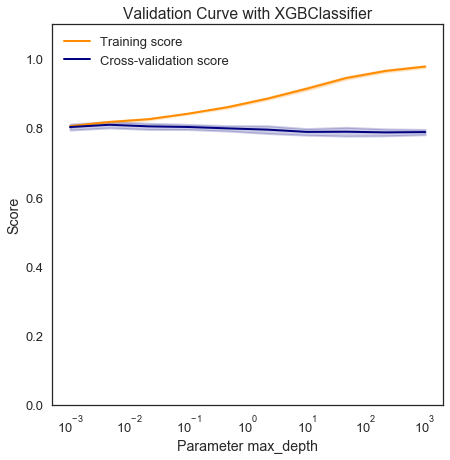

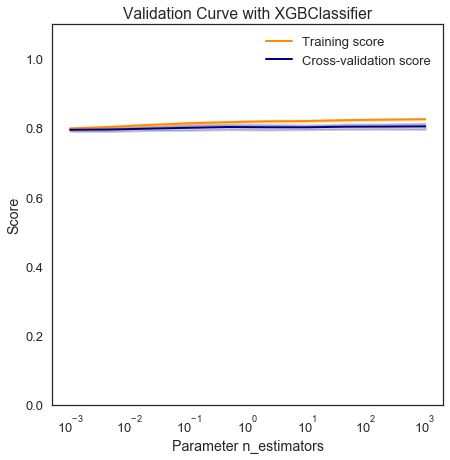

In [99]:
clf = xgb.XGBClassifier(max_depth=3, n_estimators=50, learning_rate=0.05).fit(X_train_scaled, y_train)
print('Accuracy of xgboost classifier on training set: {:.2f}'
     .format(clf.score(X_train_scaled, y_train)))
print('Accuracy of xgboost classifier on test set: {:.2f}'
     .format(clf.score(X_test_scaled, y_test)))
model_selection_plot('XGBClassifier', xgb.XGBClassifier(),'max_depth', param_range = [1,2,3,4,5,6,7,8,9,10])
model_selection_plot('XGBClassifier', xgb.XGBClassifier(),'n_estimators', param_range = [10, 20, 30, 40 ,50, 60, 70, 80, 90, 100])

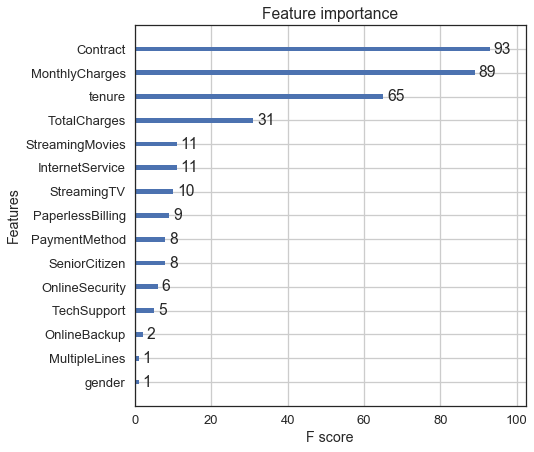

In [100]:
plt.rcParams['figure.figsize'] = (7.0, 7.0)
xgb.plot_importance(booster=clf); plt.show()

** Xgboost Classifier with feature-engineered data **: 

Accuracy of xgboost classifier on training set: 0.80
Accuracy of xgboost classifier on test set: 0.79


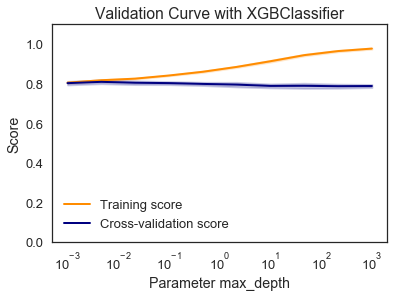

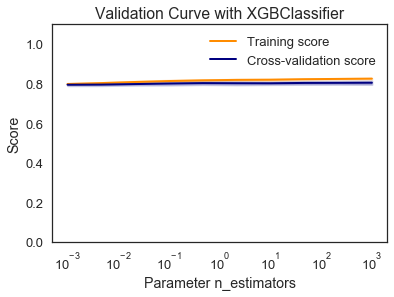

In [96]:
clf = xgb.XGBClassifier(max_depth=3, n_estimators=50, learning_rate=0.05).fit(X_train_fe_scaled, y_train)
print('Accuracy of xgboost classifier on training set: {:.2f}'
     .format(clf.score(X_train_fe_scaled, y_train)))
print('Accuracy of xgboost classifier on test set: {:.2f}'
     .format(clf.score(X_test_fe_scaled, y_test)))
model_selection_plot('XGBClassifier', xgb.XGBClassifier(),'max_depth', param_range = [1,2,3,4,5,6,7,8,9,10])
model_selection_plot('XGBClassifier', xgb.XGBClassifier(),'n_estimators', param_range = [10, 20, 30, 40 ,50, 60, 70, 80, 90, 100])

**Listed are top 15 important features in this model**

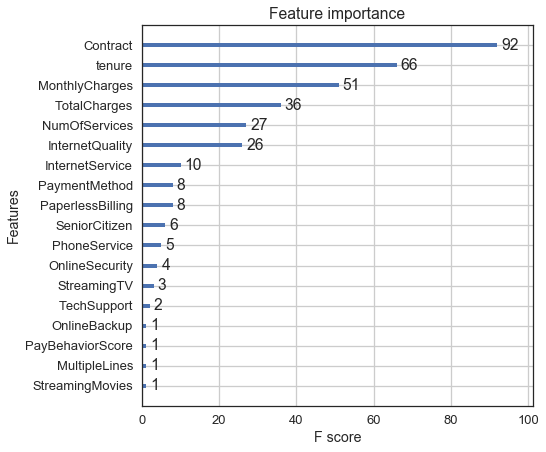

In [97]:
plt.rcParams['figure.figsize'] = (7.0, 7.0)
xgb.plot_importance(booster=clf); plt.show()

**Try 2 and 3 layer NN**

In [92]:
for units1 in [1,10,100]:
    for units2 in [1,10,100]:
        for units3 in [1,10,100]:
            nnclf = MLPClassifier(hidden_layer_sizes = [units1, units2, units3], solver='lbfgs',
                                 random_state = 0).fit(X_train_scaled, y_train)
            layer = str(units1) + ':'+ str(units2)+':'+str(units3)
            print('Accuracy of 3-layer NN classifier with '+layer+' on training set: {:.2f}'
             .format(clf.score(X_train_scaled, y_train)))
            print('Accuracy of 3-layer NN classifier with '+layer+' on test set: {:.2f}'
                 .format(clf.score(X_test_scaled, y_test)))
            [0.01, 0.1, 1.0, 5.0]

Accuracy of 3-layer NN classifier with 1:1:1 on training set: 0.80
Accuracy of 3-layer NN classifier with 1:1:1 on test set: 0.79
Accuracy of 3-layer NN classifier with 1:1:10 on training set: 0.80
Accuracy of 3-layer NN classifier with 1:1:10 on test set: 0.79
Accuracy of 3-layer NN classifier with 1:1:100 on training set: 0.80
Accuracy of 3-layer NN classifier with 1:1:100 on test set: 0.79
Accuracy of 3-layer NN classifier with 1:10:1 on training set: 0.80
Accuracy of 3-layer NN classifier with 1:10:1 on test set: 0.79
Accuracy of 3-layer NN classifier with 1:10:10 on training set: 0.80
Accuracy of 3-layer NN classifier with 1:10:10 on test set: 0.79
Accuracy of 3-layer NN classifier with 1:10:100 on training set: 0.80
Accuracy of 3-layer NN classifier with 1:10:100 on test set: 0.79
Accuracy of 3-layer NN classifier with 1:100:1 on training set: 0.80
Accuracy of 3-layer NN classifier with 1:100:1 on test set: 0.79
Accuracy of 3-layer NN classifier with 1:100:10 on training set: 0.8

In [94]:
for this_alpha in [0.01, 0.1, 1.0, 5.0] :
    nnclf = MLPClassifier(solver='lbfgs', activation = 'tanh',
                         alpha = this_alpha,
                         hidden_layer_sizes = [100, 100],
                         random_state = 0).fit(X_train_scaled, y_train)
    print('Accuracy of 2-layer NN classifier with '+str(this_alpha)+' on training set: {:.2f}'
             .format(clf.score(X_train_scaled, y_train)))
    print('Accuracy of 3-layer NN classifier with '+str(this_alpha)+' on test set: {:.2f}'
                 .format(clf.score(X_test_scaled, y_test)))

Accuracy of 2-layer NN classifier with 0.01 on training set: 0.80
Accuracy of 3-layer NN classifier with 0.01 on test set: 0.79
Accuracy of 2-layer NN classifier with 0.1 on training set: 0.80
Accuracy of 3-layer NN classifier with 0.1 on test set: 0.79
Accuracy of 2-layer NN classifier with 1.0 on training set: 0.80
Accuracy of 3-layer NN classifier with 1.0 on test set: 0.79
Accuracy of 2-layer NN classifier with 5.0 on training set: 0.80
Accuracy of 3-layer NN classifier with 5.0 on test set: 0.79


**Since the optimal accuracy has already achieved by 1-unit 1-layer NN, which is logistic regression, tunning alpha and number of layers or units per layer is meaningless.**

## 5. Conclusion: 

Due to the limit of the dataset, different models with optimal parameters can only reach at most test accuracy of about 0.8. After feature engineering, there is a slight improvement to the accuracy score. The reason why there is no major improvement is because this dataset was mainly used to do data visualization and the features of the dataset are mostly categorical data and they don't actually represent the main reasons why customers churn.

This dataset was mainly used to do data visualization, not for the purpose of predictive modeling. But with this dataset, I am able to go through steps from data cleaning, exploratory data analysis, feature engineering and modeling with different algorithms and tune the parameters.

The top 15 important features output by Xgboost Model are quite the same to the result of analysing correlation plot.

So the most important features in this dataset to predict churn or not are: 
1. Contract,
2. tenure, 
3. MonthlyCharges,
4. TotalCharges,
5. NumberOfServices (Constructed feature),
6. InternetQuality (Constructed feature),
7. InternetService (Modified feature),
8. PaymentMethod, 
9. PaperlessBilling, 
10. SeniorCitizen,
11. PhoneService,
...